### HUMAN ACTION DECTECTION IN AERIAL VIDEOS

Human action detection in videos (i.e., series of images) plays an important role in various real-life applications (e.g., visual surveillance and automated driver assistance, surveillance to image and video understanding). Aerial human action detection has several other applications like surveillance using Unmanned Aerial Vehicle (UAV), which provides a wider range of view, higher performance, search and rescue tasks, and human interaction understanding.

The objective of this project is to analyse and provide a novel approach
for human action detection using deep learning.
I try to establish a specific pattern in my proposed approach.

With rigorous literature survey and reviews of current approches towards the task of human action detection,
I have selected Okutama dataset for human action detection.

Challenges of HAR in aerial videos:

1) Variation of human sizes in videos.

2) Changing of altitude of the platform that camera is attached to.

3) Apperance of actor fades as resolution decreases.

In [1]:
import numpy as np
import pandas as pd

#Plotting 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 

# Importing sklearn libraries
from sklearn.metrics import confusion_matrix, accuracy_score

# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 

Using TensorFlow backend.


In [2]:
import os
train = [os.path.join("C:/Users/ANSH DESAI/Desktop/frames_rnn/train/",img) for img in os.listdir("C:/Users/ANSH DESAI/Desktop/frames_rnn/train")]
val = [os.path.join("C:/Users/ANSH DESAI/Desktop/frames_rnn/validation/",img) for img in os.listdir("C:/Users/ANSH DESAI/Desktop/frames_rnn/validation")]
test = [os.path.join("C:/Users/ANSH DESAI/Desktop/frames_rnn/test/",img) for img in os.listdir("C:/Users/ANSH DESAI/Desktop/frames_rnn/test/")]

In [3]:
len(train),len(val),len(test)

(6733, 1155, 1101)

In [113]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 9
 
# Convert class labels in one hot encoded vector
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)
train_y[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [5]:
len(train_y),len(val_y),len(test_y)

(6733, 1155, 1101)

Training data available in 9 classes
[705, 755, 734, 770, 725, 685, 793, 786, 780]


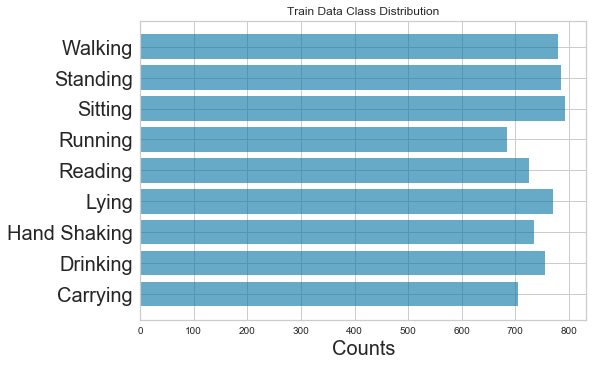

In [196]:
print("Training data available in 9 classes")
print([train_y.count(i) for i in range(0,9)])
 
action_classes = ('Carrying','Drinking','Hand Shaking','Lying','Reading','Running','Sitting','Standing','Walking')
 
y_pos = np.arange(len(_classes))
counts = [train_y.count(i) for i in range(0,9)]
 
plt.barh(y_pos, counts, align='center', alpha=0.6)
plt.yticks(y_pos, food_classes,fontsize=20)
plt.xlabel('Counts',fontsize=20)
plt.title('Train Data Class Distribution')
plt.show()

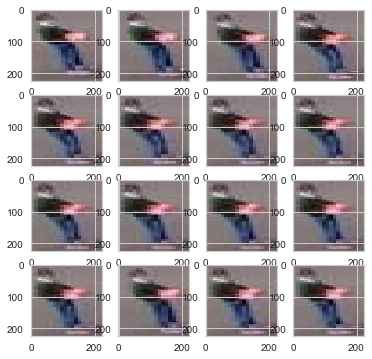

In [199]:
def show_imgs(X):
    plt.figure(figsize=(6, 6))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    plt.show()
show_imgs(train)

In [8]:
model = VGG16(weights="imagenet", include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

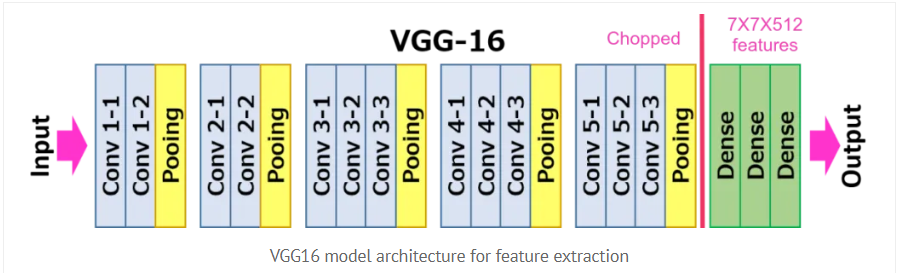

In [9]:
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

In [10]:
train_x, train_features, train_features_flatten = create_features(train, model)
#val_x, val_features, val_features_flatten = create_features(val, model)
#test_x, test_features, test_features_flatten = create_features(test, model)
 
print(train_x.shape, train_features.shape, train_features_flatten.shape)
#print(val_x.shape, val_features.shape, val_features_flatten.shape)
#print(test_x.shape, test_features.shape, test_features_flatten.shape)

(6733, 224, 224, 3) (6733, 7, 7, 512) (6733, 25088)


In [11]:
val_x, val_features, val_features_flatten = create_features(val, model)

In [12]:
print(val_x.shape, val_features.shape, val_features_flatten.shape)

(1155, 224, 224, 3) (1155, 7, 7, 512) (1155, 25088)


In [13]:
test_x, test_features, test_features_flatten = create_features(test, model)
print(test_x.shape, test_features.shape, test_features_flatten.shape)

(1101, 224, 224, 3) (1101, 7, 7, 512) (1101, 25088)


In [20]:
#np.save("D:/train_features.npy",train_features)
#np.save("D:/val_features.npy",val_features)
#np.save("D:/test_features.npy",test_features)
train_features = "D:/train_features.npy"
val_features = "D:/val_features.npy"
test_features = "D:/test_features.npy"

In [14]:
train_features.shape

(6733, 7, 7, 512)

In [15]:
train_features = train_features.reshape(train_features.shape[0],train_features.shape[1]*train_features.shape[2],train_features.shape[3])

In [16]:
train_features.shape

(6733, 49, 512)

In [17]:
val_features.shape

(1155, 7, 7, 512)

In [18]:
val_features = val_features.reshape(val_features.shape[0],val_features.shape[1]*val_features.shape[2],val_features.shape[3])

In [19]:
val_features.shape

(1155, 49, 512)

In [156]:
from matplotlib import pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_history_2win(history):
    plt.subplot(211)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='g', label='Train')
    plt.plot(history.history['val_accuracy'], color='b', label='Validation')
    #plt.plot(history.history['test_accuracy'], color='b', label='Test')
    
    plt.legend(loc='best')

    plt.subplot(212)
    plt.title('Loss')
    plt.plot(history.history['loss'], color='g', label='Train')
    plt.plot(history.history['val_loss'], color='b', label='Validation')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


def create_history_plot(history, model_name, metrics):
    plt.title('Accuracy and Loss (' + model_name + ')')
    if metrics is None:
        metrics = {'accuracy', 'loss'}
    if 'accuracy' in metrics:
        plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
    if 'loss' in metrics:
        plt.plot(history.history['loss'], color='r', label='Train Loss')
        plt.plot(history.history['val_loss'], color='m', label='Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout()


def plot_history(history, model_name):
    create_history_plot(history, model_name)
    plt.show()


def plot_and_save_history(history, model_name, file_path, metrics):
    #if metrics is None:
        #metrics = {'acc', 'loss'}
    create_history_plot(history, model_name, metrics)
    plt.savefig(file_path)


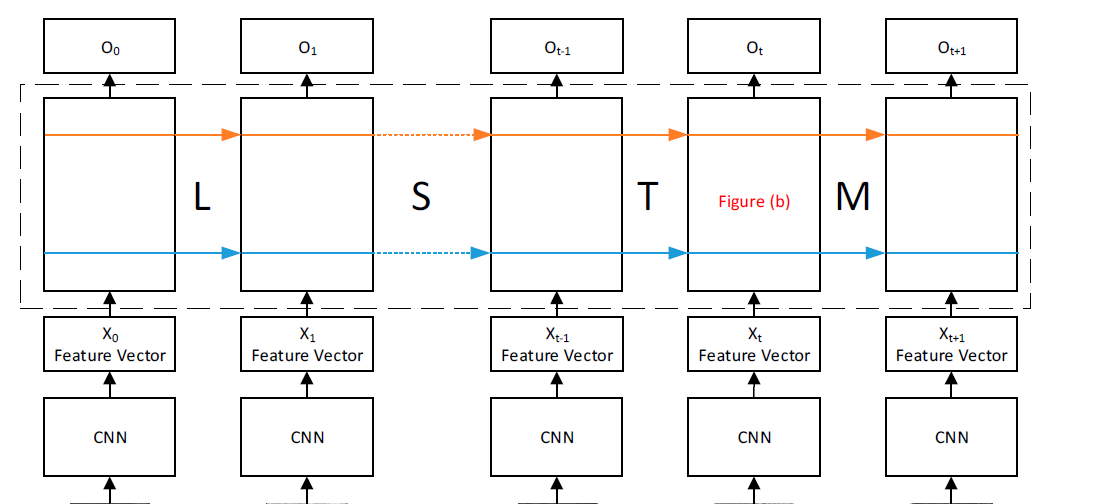

In [126]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Dropout
BATCH_SIZE = 64
NUM_EPOCHS = 10
VERBOSE = 1
HIDDEN_UNITS = 512
nb_classes = 9
def create_model():
        model1 = Sequential()

        model1.add(
            LSTM(units=HIDDEN_UNITS, input_shape=(49,512), return_sequences=False, dropout=0.5))
        model1.add(Dense(512, activation='relu'))
        model1.add(Dropout(0.5))
        model1.add(Dense(nb_classes))
        model1.add(Activation('softmax'))

        model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        return model1
model1 = create_model()
print("LSTM Model created")

LSTM Model created


In [149]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 4617      
_________________________________________________________________
activation_6 (Activation)    (None, 9)                 0         
Total params: 2,366,473
Trainable params: 2,366,473
Non-trainable params: 0
_________________________________________________________________


In [100]:
checkpointer = ModelCheckpoint(filepath='model1_scr.best.hdf5',
                               verbose=1,save_best_only=True)
checkpoint = ModelCheckpoint(filepath="D:/", save_best_only=True)
print("checkpoint created")
history = model1.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

checkpoint created
Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 19s 3ms/step - loss: 1.0736 - accuracy: 0.6248 - val_loss: 1.2254 - val_accuracy: 0.6537

Epoch 00001: val_loss improved from inf to 1.22540, saving model to model1_scr.best.hdf5
Epoch 2/10
6733/6733 [==============================] - 19s 3ms/step - loss: 0.4725 - accuracy: 0.8359 - val_loss: 0.8932 - val_accuracy: 0.7723

Epoch 00002: val_loss improved from 1.22540 to 0.89319, saving model to model1_scr.best.hdf5
Epoch 3/10
6733/6733 [==============================] - 18s 3ms/step - loss: 0.2902 - accuracy: 0.8992 - val_loss: 0.6538 - val_accuracy: 0.8476

Epoch 00003: val_loss improved from 0.89319 to 0.65384, saving model to model1_scr.best.hdf5
Epoch 4/10
6733/6733 [==============================] - 17s 3ms/step - loss: 0.2220 - accuracy: 0.9244 - val_loss: 0.6014 - val_accuracy: 0.8407

Epoch 00004: val_loss improved from 0.65384 to 0.60144, saving model to mo

In [22]:
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1]*test_features.shape[2],test_features.shape[3])

In [104]:
import sklearn
preds = np.argmax(model1.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,9))


Accuracy on Test Data:  0.7620345140781108

Number of correctly identified imgaes:  839 



array([[ 95,   8,   0,   0,  29,  15,   0,   0,   0],
       [  0, 122,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,  96,   0,   1,   3,   0,   4,  27],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 22,  19,   0,   0,  58,   2,  16,   0,  20],
       [  4,  25,   0,   9,   0, 110,   2,   0,   2],
       [  0,  19,   0,   0,   2,   0,  74,   0,   1],
       [  0,   0,   3,   0,   0,   0,   0,  86,   0],
       [  0,   0,  20,   0,   0,   4,   0,   3,  83]], dtype=int64)

In [157]:
print(sklearn.metrics.classification_report(test_y, preds, labels=None, target_names=names, sample_weight=None, digits=2, output_dict=False))

              precision    recall  f1-score   support

    Carrying       0.79      0.65      0.71       147
    Drinking       0.63      1.00      0.77       122
Hand Shaking       0.81      0.72      0.76       133
       Lying       0.93      1.00      0.96       115
     Reading       0.64      0.42      0.51       137
     Running       0.82      0.72      0.77       152
     Sitting       0.80      0.77      0.79        96
    Standing       0.92      0.97      0.95        89
     Walking       0.62      0.75      0.68       110

    accuracy                           0.76      1101
   macro avg       0.77      0.78      0.77      1101
weighted avg       0.77      0.76      0.76      1101



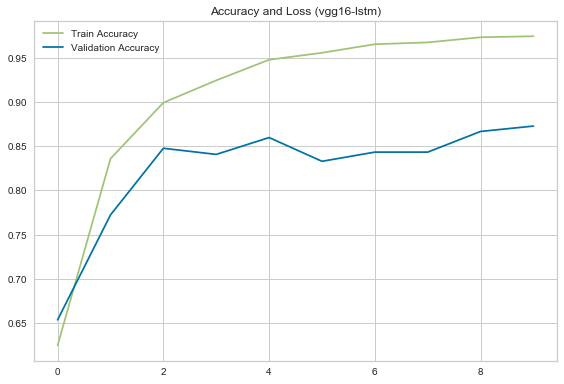

In [124]:
plot_and_save_history(history,'vgg16-lstm' , 'D:/' + 'lstm'+ '-history.png','accuracy')

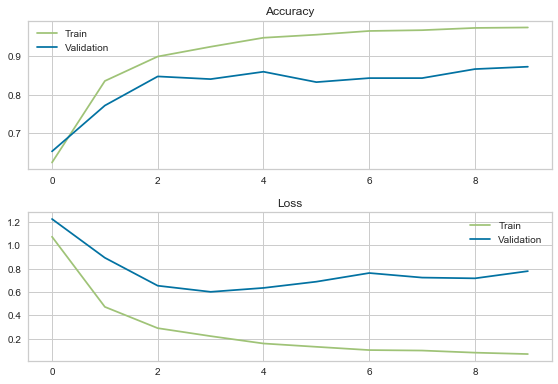

In [125]:
plot_history_2win(history)

In [127]:
def create_model_bilstm():
        model_bilstm = Sequential()
        model_bilstm.add(Bidirectional(LSTM(units=HIDDEN_UNITS, return_sequences=True),
                                input_shape=(train_features.shape[1],train_features.shape[2])))
        model_bilstm.add(Bidirectional(LSTM(10)))
        model_bilstm.add(Dense(512, activation='relu'))
        model_bilstm.add(Dropout(0.5))

        model_bilstm.add(Dense(nb_classes))

        model_bilstm.add(Activation('softmax'))

        model_bilstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        return model_bilstm

In [128]:
model_bilstm = create_model_bilstm()

In [148]:
model_bilstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 49, 1024)          4198400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 20)                82800     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               10752     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 4617      
_________________________________________________________________
activation_7 (Activation)    (None, 9)                 0         
Total params: 4,296,569
Trainable params: 4,296,569
Non-trainable params: 0
____________________________________________

In [129]:
checkpointer = ModelCheckpoint(filepath='scratchbilstm.best.hdf5',
                               verbose=1,save_best_only=True)
#checkpoint = ModelCheckpoint(filepath="D:/", save_best_only=True)
print("checkpoint created")
history = model_bilstm.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

checkpoint created
Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 52s 8ms/step - loss: 0.6527 - accuracy: 0.8135 - val_loss: 0.5777 - val_accuracy: 0.8476

Epoch 00001: val_loss improved from inf to 0.57767, saving model to scratchbilstm.best.hdf5
Epoch 2/10
6733/6733 [==============================] - 50s 7ms/step - loss: 0.0792 - accuracy: 0.9770 - val_loss: 0.6315 - val_accuracy: 0.8407

Epoch 00002: val_loss did not improve from 0.57767
Epoch 3/10
6733/6733 [==============================] - 49s 7ms/step - loss: 0.0474 - accuracy: 0.9849 - val_loss: 0.6041 - val_accuracy: 0.8667

Epoch 00003: val_loss did not improve from 0.57767
Epoch 4/10
6733/6733 [==============================] - 49s 7ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.6103 - val_accuracy: 0.8727

Epoch 00004: val_loss did not improve from 0.57767
Epoch 5/10
6733/6733 [==============================] - 50s 7ms/step - loss: 0.0181 - accuracy: 0.9947 -

In [131]:
predsq = np.argmax(model_bilstm.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, predsq))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, predsq, normalize=False),"\n")
confusion_matrix(test_y, predsq, labels=range(0,9))


Accuracy on Test Data:  0.7901907356948229

Number of correctly identified imgaes:  870 



array([[111,   0,   0,   0,  31,   0,   0,   0,   5],
       [  1, 118,   3,   0,   0,   0,   0,   0,   0],
       [  0,   0,  89,   3,   0,   8,   0,   2,  31],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 29,   8,   0,   0,  59,   6,  11,   0,  24],
       [ 19,  22,   0,   2,   3, 106,   0,   0,   0],
       [  0,   0,   7,   0,   3,   0,  81,   0,   5],
       [  0,   0,   2,   0,   0,   0,   0,  84,   3],
       [  0,   0,   3,   0,   0,   0,   0,   0, 107]], dtype=int64)

In [155]:
print(sklearn.metrics.classification_report(test_y, predsq, labels=None, target_names=names, sample_weight=None, digits=2, output_dict=False))

              precision    recall  f1-score   support

    Carrying       0.69      0.76      0.72       147
    Drinking       0.80      0.97      0.87       122
Hand Shaking       0.86      0.67      0.75       133
       Lying       0.96      1.00      0.98       115
     Reading       0.61      0.43      0.51       137
     Running       0.88      0.70      0.78       152
     Sitting       0.88      0.84      0.86        96
    Standing       0.98      0.94      0.96        89
     Walking       0.61      0.97      0.75       110

    accuracy                           0.79      1101
   macro avg       0.81      0.81      0.80      1101
weighted avg       0.80      0.79      0.78      1101



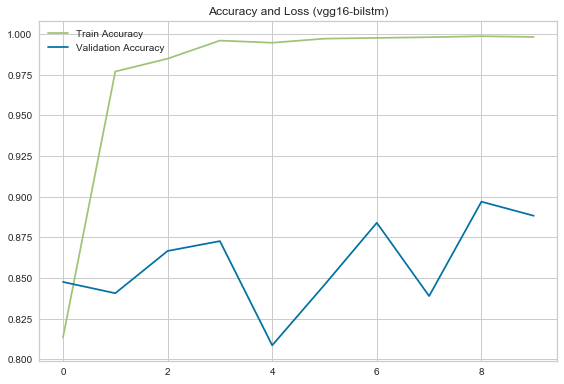

In [133]:
plot_and_save_history(history,'vgg16-bilstm' , 'D:/' + 'bilstm'+ '-history.png','accuracy')

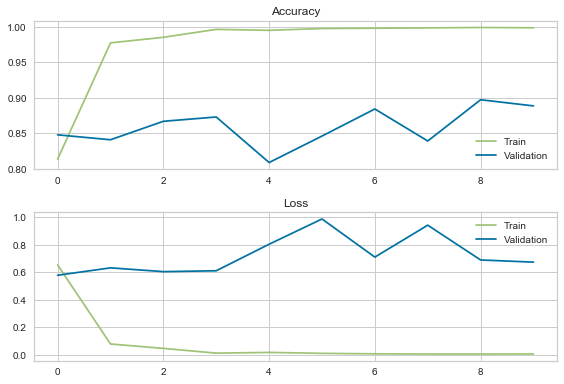

In [134]:
plot_history_2win(history)

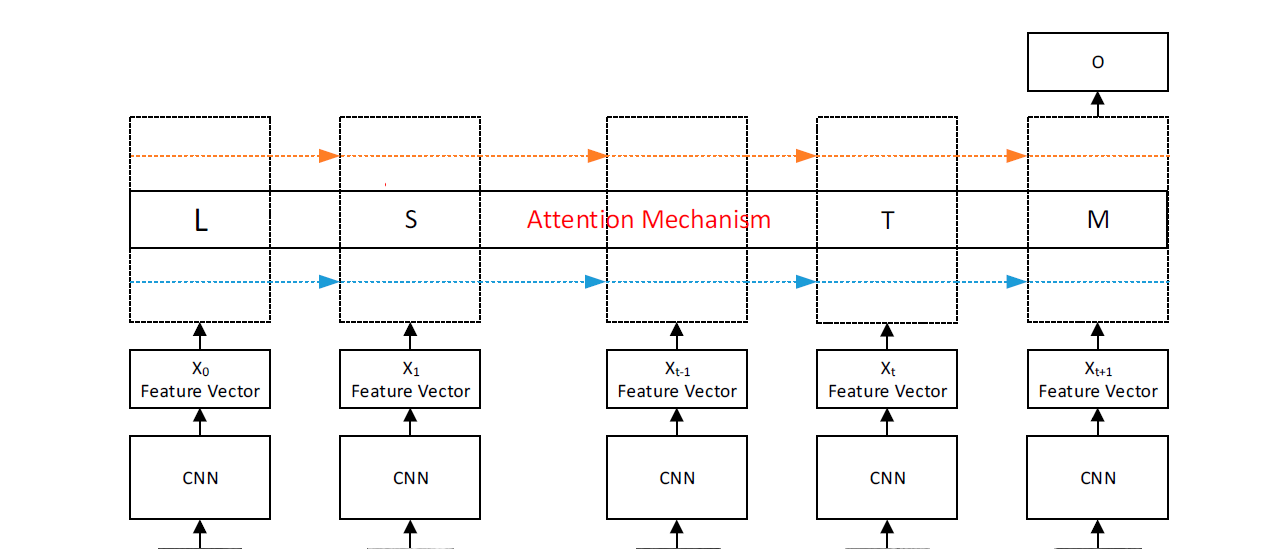

In [135]:
from keras.layers import Dense, Lambda, dot, Activation, concatenate


def attention_3d_block(hidden_states):
    hidden_size = int(hidden_states.shape[2])
    
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    
    attention_weights = Activation('softmax', name='attention_weight')(score)
    
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    
    return attention_vector

In [136]:
import keras
from keras import Input
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import np_utils
from keras import Model
from keras.layers import Dense, Activation, Dropout, Bidirectional,RepeatVector,Permute
BATCH_SIZE = 64
NUM_EPOCHS = 10
VERBOSE = 1
HIDDEN_UNITS = 512
#num_input_tokens = 7
nb_classes = 9
#from keras_self_attention import SeqSelfAttention
i = Input(shape=(49, 512))
x = LSTM(512, return_sequences=True)(i)
x = attention_3d_block(x)
x = Dropout(0.2)(x)
x = Dense(9, activation='linear')(x)

modela = Model(inputs=[i], outputs=[x])
modela.compile(loss='mse', optimizer='adam')
print(modela.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 49, 512)      0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 49, 512)      2099200     input_2[0][0]                    
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 49, 512)      262144      lstm_11[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 512)          0           lstm_11[0][0]                    
____________________________________________________________________________________________

In [137]:
check_att0 = ModelCheckpoint(filepath='scratch_ATT0.best.hdf5',
                               verbose=1,save_best_only=True)
check_att0 = ModelCheckpoint(filepath="D:/check_att", save_best_only=True)
print("checkpoint created")
history_a = modela.fit(train_features, y_train, batch_size=64, epochs=10,
          validation_data=(val_features, y_val), callbacks=[check_att0],
          verbose=1,shuffle=True)

checkpoint created
Train on 6733 samples, validate on 1155 samples
Epoch 1/10
6733/6733 [==============================] - 20s 3ms/step - loss: 0.1023 - val_loss: 0.0418
Epoch 2/10
6733/6733 [==============================] - 19s 3ms/step - loss: 0.0203 - val_loss: 0.0333
Epoch 3/10
6733/6733 [==============================] - 19s 3ms/step - loss: 0.0131 - val_loss: 0.0292
Epoch 4/10
6733/6733 [==============================] - 18s 3ms/step - loss: 0.0097 - val_loss: 0.0268
Epoch 5/10
6733/6733 [==============================] - 16s 2ms/step - loss: 0.0078 - val_loss: 0.0255
Epoch 6/10
6733/6733 [==============================] - 16s 2ms/step - loss: 0.0066 - val_loss: 0.0246
Epoch 7/10
6733/6733 [==============================] - 16s 2ms/step - loss: 0.0058 - val_loss: 0.0237
Epoch 8/10
6733/6733 [==============================] - 16s 2ms/step - loss: 0.0051 - val_loss: 0.0235
Epoch 9/10
6733/6733 [==============================] - 16s 2ms/step - loss: 0.0046 - val_loss: 0.0238
Epoch 

In [138]:
pred_att = np.argmax(modela.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, pred_att))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, pred_att, normalize=False),"\n")
confusion_matrix(test_y, pred_att, labels=range(0,9))


Accuracy on Test Data:  0.8228882833787466

Number of correctly identified imgaes:  906 



array([[113,   3,   0,   0,  31,   0,   0,   0,   0],
       [  0, 121,   0,   0,   1,   0,   0,   0,   0],
       [  5,   1,  98,   0,   0,  14,   0,   3,  12],
       [  0,   0,   0, 115,   0,   0,   0,   0,   0],
       [ 13,   3,   0,   1,  80,  12,  11,   1,  16],
       [ 33,   7,   0,   2,   4, 104,   2,   0,   0],
       [  0,   1,   1,   0,   1,   0,  93,   0,   0],
       [  0,   0,   4,   0,   0,   0,   0,  85,   0],
       [  0,   0,   4,   0,   0,   0,   0,   9,  97]], dtype=int64)

In [154]:
print(sklearn.metrics.classification_report(test_y, pred_att, labels=None, target_names=names, sample_weight=None, digits=2, output_dict=False))

              precision    recall  f1-score   support

    Carrying       0.69      0.77      0.73       147
    Drinking       0.89      0.99      0.94       122
Hand Shaking       0.92      0.74      0.82       133
       Lying       0.97      1.00      0.99       115
     Reading       0.68      0.58      0.63       137
     Running       0.80      0.68      0.74       152
     Sitting       0.88      0.97      0.92        96
    Standing       0.87      0.96      0.91        89
     Walking       0.78      0.88      0.83       110

    accuracy                           0.82      1101
   macro avg       0.83      0.84      0.83      1101
weighted avg       0.82      0.82      0.82      1101



CONCLUSION:

Through this three approaches , I establish a pattern which is:

    Accuracy is higher for model with LSTM + attention than LSTM and BI-LSTM models.

    Focusing on specific regions and sequential(time) models prove to be better for classification for sequential data.
    

REFRENCES AND CITATIONS:

https://www.mdpi.com/507920

Liu, Y.; Xu, K.; Xu, J. Periodic Surface Defect Detection in Steel Plates Based on Deep Learning.

Human Action Recognition using CNN and LSTM-RNN with Attention Model
Pothanaicker, Kuppusamy. (2019). Human Action Recognition using CNN and LSTM-RNN with Attention Model. 8. 1639-1643. 

Recurrently exploring class-wise attention in a hybrid convolutional and
bidirectional LSTM network for multi-label aerial image classification
https://doi.org/10.1016/j.isprsjprs.2019.01.015

FUTURE ENHANCEMENT:

    1) Spatio-temporal graph attention mechanism.
    
    2) Fine tuning of these models with (extended resources).
    
    3) Transformer model.